In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statistics

In [2]:
import sys
import os

from pathlib import Path

parent = Path(os.path.abspath("")).resolve().parents[0]
if parent not in sys.path:
    sys.path.insert(0, str(parent))

import random 
from types import SimpleNamespace

import torch

from torch.utils.data import DataLoader

from models.autoencoder import VariationalAutoEncoder, AutoEncoder
from models.mlp import MLP
from utils.data_utils import TorchDataset

from utils.metrics import get_classification_metrics, get_probability_measures, get_lift_demotion_scores

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
thefts = pd.read_csv("../dataset/final/valid_train_thefts.csv")
non_thefts = pd.read_csv("../dataset/final/valid_train_non_theft_suc_theft_acct.csv")

df = pd.concat([thefts, non_thefts])
df.drop(columns=['acct', 'successor', 'voltage'], inplace=True)
df.fillna(-1, inplace=True)

In [5]:
scaler = MinMaxScaler()

In [6]:
#df.drop(['xrhsh', 'parno', 'acct_control', 'contract_capacity', 'min_measurement_interval_in_days', 'max_energy_per_day'], axis=1, inplace=True)
print("Bincount of y:", df['target'].value_counts())

Bincount of y: 0    2094
1    1555
Name: target, dtype: int64


In [7]:
df.head()

,number_of_measurements,number_of_zeros,max_energy_per_day,min_energy_per_day,mean_energy_per_day,median_energy_per_day,std_energy_per_day,max_measurement_interval_in_days,min_measurement_interval_in_days,mean_measurement_interval_in_days,median_measurement_interval_in_days,days_since_last_measurement,parno,xrhsh,contract_capacity,acct_control,number_of_requests,target
0,12,2,18.950000,0.000000,6.735356,7.049180,4.964937,350,15,144.181818,122.0,152,0,1,12.0,0,0,1
1,13,2,12.071429,0.000000,7.221644,10.070525,4.807979,243,6,122.416667,121.0,341,0,1,12.0,0,1,1
2,5,5,0.000000,0.000000,0.000000,0.000000,0.000000,125,120,122.250000,122.0,1251,2,1,25.0,0,3,1
3,6,1,9.434066,4.546448,5.873035,4.989218,1.803735,371,68,197.200000,182.0,190,2,6,25.0,0,0,1
4,8,0,19.565574,1.910569,10.585130,10.008197,5.580233,246,121,139.142857,121.0,821,3,1,35.0,0,5,1


In [8]:
train = df[df['target'] == 0]
train, val = train_test_split(train, test_size=0.2, random_state=42, shuffle=True)

test_target1 = df[(df['target'] == 1)]

In [9]:
train.target.value_counts(), val.target.value_counts(), test_target1.target.value_counts()

(0    1675
 Name: target, dtype: int64,
 0    419
 Name: target, dtype: int64,
 1    1555
 Name: target, dtype: int64)

In [10]:
X_train = train.drop('target', axis=1)
y_train = train['target']
X_val = val.drop('target', axis=1)
y_val = val['target']
X_test_1 = test_target1.drop('target', axis=1)
y_test_1 = test_target1['target']

In [11]:
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test_1 = scaler.transform(X_test_1)

In [12]:
train_dataset = TorchDataset(
    X=torch.tensor(X_train).float(),
    y=torch.tensor(y_train.to_numpy()).float()
)  # reconstruction
val_dataset = TorchDataset(
    X=torch.tensor(X_val).float(),
    y=torch.tensor(y_val.to_numpy()).float()
)

test_dataset_one = TorchDataset(
    X=torch.tensor(X_test_1).float(),
    y=torch.tensor(y_test_1.to_numpy()).float()
)

X_test = np.concatenate([X_val, X_test_1], axis=0)
y_test = pd.concat([y_val, y_test_1])
test_dataset = TorchDataset(
    X=torch.tensor(X_test).float(),
    y=torch.tensor(y_test.to_numpy()).float()
)

In [13]:
np.bincount(y_train), np.bincount(y_val), np.bincount(y_test)

(array([1675]), array([419]), array([ 419, 1555]))

In [14]:
train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=False
)
val_loader = DataLoader(
    val_dataset, batch_size=32, shuffle=False
)
test_loader = DataLoader(
    test_dataset, batch_size=1, shuffle=False
)
test_zero = DataLoader(
    test_dataset_one, batch_size=1, shuffle=False
)

In [15]:
encoder = MLP(
    in_size=X_train.shape[1],
    layer_units=[16, 8],
    out_size=4,
    vae=False)
decoder = MLP(
    in_size=4, 
    layer_units=[8, 16],
    out_size=X_train.shape[1]
)
model = AutoEncoder(encoder, decoder)
model

AutoEncoder(
  (encoder): MLP(
    (MLP): Sequential(
      (0): Linear(in_features=17, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=8, bias=True)
      (3): ReLU()
      (4): Linear(in_features=8, out_features=4, bias=True)
    )
  )
  (decoder): MLP(
    (MLP): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=16, bias=True)
      (3): ReLU()
      (4): Linear(in_features=16, out_features=17, bias=True)
    )
  )
)

In [16]:
optimizer = torch.optim.Adam(model.parameters(), 
                                 lr=1e-3, weight_decay=1e-5)
criterion = torch.nn.SmoothL1Loss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    
args = dict(model=model, train_loader=train_loader, 
            test_loader=val_loader,
            epochs=1_000, optimizer=optimizer, 
            criterion=criterion,
            reconstruction=True, vae=False,
            device=device, verbose=True, return_best=True)

Epoch: 1/1000
[Train]	Loss=0.08970576229522813
[Test]	Loss=0.06785708985158376

Epoch: 2/1000
[Train]	Loss=0.03289960632276422
[Test]	Loss=0.011382210068404675

Epoch: 3/1000
[Train]	Loss=0.009402780073150149
[Test]	Loss=0.009271141873406512

Epoch: 4/1000
[Train]	Loss=0.008599572648065832
[Test]	Loss=0.008862487539382917

Epoch: 5/1000
[Train]	Loss=0.008286413639994725
[Test]	Loss=0.008609342754685454

Epoch: 6/1000
[Train]	Loss=0.008027263934601028
[Test]	Loss=0.008354167986129011

Epoch: 7/1000
[Train]	Loss=0.007738111777898838
[Test]	Loss=0.008026947267353535

Epoch: 8/1000
[Train]	Loss=0.0073097344962352855
[Test]	Loss=0.007479040750435421

Epoch: 9/1000
[Train]	Loss=0.0065034176838004365
[Test]	Loss=0.0064411715803934

Epoch: 10/1000
[Train]	Loss=0.005306654297834578
[Test]	Loss=0.005411555890792182

Epoch: 11/1000
[Train]	Loss=0.00456855906050582
[Test]	Loss=0.0049302903935313225

Epoch: 12/1000
[Train]	Loss=0.004160927028729106
[Test]	Loss=0.004549269913695753

Epoch: 13/1000
[

Epoch: 99/1000
[Train]	Loss=0.0015799135270633928
[Test]	Loss=0.0016126794923496033

Epoch: 100/1000
[Train]	Loss=0.0015750901525365716
[Test]	Loss=0.0016076286057276385

Epoch: 101/1000
[Train]	Loss=0.001569866094044146
[Test]	Loss=0.0016026479923831566

Epoch: 102/1000
[Train]	Loss=0.001564356496223723
[Test]	Loss=0.00159672019903415

Epoch: 103/1000
[Train]	Loss=0.001558014850641759
[Test]	Loss=0.001590617441771818

Epoch: 104/1000
[Train]	Loss=0.0015518117294084492
[Test]	Loss=0.0015813912281633488

Epoch: 105/1000
[Train]	Loss=0.0015413345986502772
[Test]	Loss=0.0015705445132750487

Epoch: 106/1000
[Train]	Loss=0.001529157754771833
[Test]	Loss=0.0015569496276189706

Epoch: 107/1000
[Train]	Loss=0.0015146775766416401
[Test]	Loss=0.0015413175403539623

Epoch: 108/1000
[Train]	Loss=0.0014984397248382557
[Test]	Loss=0.0015208681122333343

Epoch: 109/1000
[Train]	Loss=0.0014749440059223969
[Test]	Loss=0.0014954275684431195

Epoch: 110/1000
[Train]	Loss=0.0014481276289103025
[Test]	Loss

Epoch: 195/1000
[Train]	Loss=0.0009440500250762716
[Test]	Loss=0.0008638103900011629

Epoch: 196/1000
[Train]	Loss=0.0009424926758137584
[Test]	Loss=0.0008615423222571346

Epoch: 197/1000
[Train]	Loss=0.0009413771836508839
[Test]	Loss=0.0008612972950296742

Epoch: 198/1000
[Train]	Loss=0.0009404163140988083
[Test]	Loss=0.0008604809097180675

Epoch: 199/1000
[Train]	Loss=0.0009394095944820569
[Test]	Loss=0.0008589680219301954

Epoch: 200/1000
[Train]	Loss=0.0009388841369039959
[Test]	Loss=0.0008577847828356815

Epoch: 201/1000
[Train]	Loss=0.000937503106334194
[Test]	Loss=0.0008566184322782126

Epoch: 202/1000
[Train]	Loss=0.0009365008258752806
[Test]	Loss=0.0008559234619107363

Epoch: 203/1000
[Train]	Loss=0.0009352446188886632
[Test]	Loss=0.0008545448300927612

Epoch: 204/1000
[Train]	Loss=0.0009345309808850288
[Test]	Loss=0.0008528370526619256

Epoch: 205/1000
[Train]	Loss=0.0009336375811506274
[Test]	Loss=0.0008519985130988061

Epoch: 206/1000
[Train]	Loss=0.0009321027906514915
[Tes

Epoch: 291/1000
[Train]	Loss=0.0007511062568431404
[Test]	Loss=0.0007417296458567892

Epoch: 292/1000
[Train]	Loss=0.000750133301513621
[Test]	Loss=0.0007408461471121493

Epoch: 293/1000
[Train]	Loss=0.0007490416602143701
[Test]	Loss=0.0007413985087103876

Epoch: 294/1000
[Train]	Loss=0.0007488671443117606
[Test]	Loss=0.0007410584720284012

Epoch: 295/1000
[Train]	Loss=0.0007486813795041153
[Test]	Loss=0.0007403029282743644

Epoch: 296/1000
[Train]	Loss=0.0007478940099662275
[Test]	Loss=0.0007414228603010997

Epoch: 297/1000
[Train]	Loss=0.0007481981982600015
[Test]	Loss=0.0007412039163422637

Epoch: 298/1000
[Train]	Loss=0.0007471442409299032
[Test]	Loss=0.0007411550759570673

Epoch: 299/1000
[Train]	Loss=0.000746823699029057
[Test]	Loss=0.0007409910841878238

Epoch: 300/1000
[Train]	Loss=0.0007468107302523798
[Test]	Loss=0.0007398889096553571

Epoch: 301/1000
[Train]	Loss=0.0007458572234202809
[Test]	Loss=0.0007403389130818791

Epoch: 302/1000
[Train]	Loss=0.0007461042391610736
[Test

Epoch: 387/1000
[Train]	Loss=0.0007178518511486714
[Test]	Loss=0.0007227975209908826

Epoch: 388/1000
[Train]	Loss=0.0007171641605827114
[Test]	Loss=0.0007209210452856496

Epoch: 389/1000
[Train]	Loss=0.0007166097787393362
[Test]	Loss=0.0007213419989316858

Epoch: 390/1000
[Train]	Loss=0.0007171564035882013
[Test]	Loss=0.0007228855933395348

Epoch: 391/1000
[Train]	Loss=0.0007157765525472263
[Test]	Loss=0.0007206444300079186

Epoch: 392/1000
[Train]	Loss=0.0007159247690205515
[Test]	Loss=0.0007200165626792503

Epoch: 393/1000
[Train]	Loss=0.0007156996014703698
[Test]	Loss=0.00072188485812928

Epoch: 394/1000
[Train]	Loss=0.0007147908250291674
[Test]	Loss=0.0007206782839992749

Epoch: 395/1000
[Train]	Loss=0.00071553770125457
[Test]	Loss=0.0007201474446836593

Epoch: 396/1000
[Train]	Loss=0.0007147212679726335
[Test]	Loss=0.000721598112639705

Epoch: 397/1000
[Train]	Loss=0.0007144947221089717
[Test]	Loss=0.0007182079508701074

Epoch: 398/1000
[Train]	Loss=0.000713036435146658
[Test]	Lo

Epoch: 483/1000
[Train]	Loss=0.0006039958553748944
[Test]	Loss=0.0006708630867901125

Epoch: 484/1000
[Train]	Loss=0.0006032799099317208
[Test]	Loss=0.0006705880743019017

Epoch: 485/1000
[Train]	Loss=0.0006027352284499497
[Test]	Loss=0.0006699663998525855

Epoch: 486/1000
[Train]	Loss=0.0006026396619041785
[Test]	Loss=0.0006695102077044014

Epoch: 487/1000
[Train]	Loss=0.0006020325104231542
[Test]	Loss=0.0006689559813821688

Epoch: 488/1000
[Train]	Loss=0.000601650071813602
[Test]	Loss=0.0006689146560217653

Epoch: 489/1000
[Train]	Loss=0.0006011380431822167
[Test]	Loss=0.0006685928528895602

Epoch: 490/1000
[Train]	Loss=0.000601092019592816
[Test]	Loss=0.0006682946737523057

Epoch: 491/1000
[Train]	Loss=0.0006004259086934463
[Test]	Loss=0.0006680547189067251

Epoch: 492/1000
[Train]	Loss=0.000600418766723278
[Test]	Loss=0.0006680715097380536

Epoch: 493/1000
[Train]	Loss=0.000599995223620801
[Test]	Loss=0.0006672784760926983

Epoch: 494/1000
[Train]	Loss=0.0005996303208927922
[Test]	

Epoch: 579/1000
[Train]	Loss=0.0005814113493850631
[Test]	Loss=0.0006489904127582642

Epoch: 580/1000
[Train]	Loss=0.0005815228110152946
[Test]	Loss=0.0006486294940779251

Epoch: 581/1000
[Train]	Loss=0.000581178568712137
[Test]	Loss=0.0006477549946534314

Epoch: 582/1000
[Train]	Loss=0.0005808762985255288
[Test]	Loss=0.0006482482733969976

Epoch: 583/1000
[Train]	Loss=0.000580783220631826
[Test]	Loss=0.0006478088907897472

Epoch: 584/1000
[Train]	Loss=0.0005810633054626929
[Test]	Loss=0.0006477675529562735

Epoch: 585/1000
[Train]	Loss=0.0005804908918743988
[Test]	Loss=0.0006478859618904867

Epoch: 586/1000
[Train]	Loss=0.0005801678739514484
[Test]	Loss=0.0006475822301581502

Epoch: 587/1000
[Train]	Loss=0.000580194709330516
[Test]	Loss=0.0006474694278689899

Epoch: 588/1000
[Train]	Loss=0.0005800990329589695
[Test]	Loss=0.0006473125104093924

Epoch: 589/1000
[Train]	Loss=0.0005801393692205959
[Test]	Loss=0.0006474764938632559

Epoch: 590/1000
[Train]	Loss=0.0005799331817609029
[Test]

Epoch: 675/1000
[Train]	Loss=0.0005690065901155391
[Test]	Loss=0.0006379146548819595

Epoch: 676/1000
[Train]	Loss=0.0005684162040882445
[Test]	Loss=0.0006377853715093806

Epoch: 677/1000
[Train]	Loss=0.0005690307677108443
[Test]	Loss=0.0006380954707440521

Epoch: 678/1000
[Train]	Loss=0.000568768565261842
[Test]	Loss=0.0006374086972625394

Epoch: 679/1000
[Train]	Loss=0.0005685564840019171
[Test]	Loss=0.0006384003874180573

Epoch: 680/1000
[Train]	Loss=0.0005683813646066723
[Test]	Loss=0.0006372135831043124

Epoch: 681/1000
[Train]	Loss=0.0005682389068478753
[Test]	Loss=0.000637936351787565

Epoch: 682/1000
[Train]	Loss=0.0005683023312331159
[Test]	Loss=0.0006377827646377097

Epoch: 683/1000
[Train]	Loss=0.000568445060261578
[Test]	Loss=0.000637181119860283

Epoch: 684/1000
[Train]	Loss=0.0005680629395976452
[Test]	Loss=0.0006374909238989598

Epoch: 685/1000
[Train]	Loss=0.0005682929350889095
[Test]	Loss=0.000637095284348886

Epoch: 686/1000
[Train]	Loss=0.0005676730070263147
[Test]	L

Epoch: 771/1000
[Train]	Loss=0.0005606550301583308
[Test]	Loss=0.0006324848530182083

Epoch: 772/1000
[Train]	Loss=0.0005606163242603388
[Test]	Loss=0.0006327076366038195

Epoch: 773/1000
[Train]	Loss=0.0005609838677491149
[Test]	Loss=0.0006329156084185732

Epoch: 774/1000
[Train]	Loss=0.0005604557128500123
[Test]	Loss=0.0006325906329688483

Epoch: 775/1000
[Train]	Loss=0.0005607397310910219
[Test]	Loss=0.0006325289661098006

Epoch: 776/1000
[Train]	Loss=0.0005602576920349713
[Test]	Loss=0.0006325774489336514

Epoch: 777/1000
[Train]	Loss=0.0005602380683654392
[Test]	Loss=0.0006326809400759105

Epoch: 778/1000
[Train]	Loss=0.0005603932631685275
[Test]	Loss=0.0006325582154594096

Epoch: 779/1000
[Train]	Loss=0.0005597761131489193
[Test]	Loss=0.0006319784027125154

Epoch: 780/1000
[Train]	Loss=0.0005601852888434703
[Test]	Loss=0.0006325141356293378

Epoch: 781/1000
[Train]	Loss=0.0005601210237419198
[Test]	Loss=0.0006323955354413816

Epoch: 782/1000
[Train]	Loss=0.0005599283404595588
[Te

Epoch: 867/1000
[Train]	Loss=0.0005530487089242153
[Test]	Loss=0.0006292514798198161

Epoch: 868/1000
[Train]	Loss=0.0005534486922013732
[Test]	Loss=0.0006293246551649645

Epoch: 869/1000
[Train]	Loss=0.0005534155176785546
[Test]	Loss=0.0006297196752192187

Epoch: 870/1000
[Train]	Loss=0.0005531247369154304
[Test]	Loss=0.0006293061742326245

Epoch: 871/1000
[Train]	Loss=0.000553230678702195
[Test]	Loss=0.0006291355363958116

Epoch: 872/1000
[Train]	Loss=0.0005534146215002281
[Test]	Loss=0.0006291264310545687

Epoch: 873/1000
[Train]	Loss=0.0005529058783069113
[Test]	Loss=0.0006288271334986868

Epoch: 874/1000
[Train]	Loss=0.0005528673003559475
[Test]	Loss=0.0006296290354969512

Epoch: 875/1000
[Train]	Loss=0.0005531435758797979
[Test]	Loss=0.000628568242453704

Epoch: 876/1000
[Train]	Loss=0.000552713289474717
[Test]	Loss=0.0006291308361271929

Epoch: 877/1000
[Train]	Loss=0.0005528626338587546
[Test]	Loss=0.000629074709390157

Epoch: 878/1000
[Train]	Loss=0.0005526737302304509
[Test]	

Epoch: 963/1000
[Train]	Loss=0.0005475320174569651
[Test]	Loss=0.0006258182423022975

Epoch: 964/1000
[Train]	Loss=0.0005473879139589251
[Test]	Loss=0.000625737988489813

Epoch: 965/1000
[Train]	Loss=0.0005473957346523848
[Test]	Loss=0.0006252257797833798

Epoch: 966/1000
[Train]	Loss=0.0005472786795954167
[Test]	Loss=0.0006253543542698026

Epoch: 967/1000
[Train]	Loss=0.0005474219451227911
[Test]	Loss=0.0006247874220467306

Epoch: 968/1000
[Train]	Loss=0.000547386046371616
[Test]	Loss=0.0006252338020463607

Epoch: 969/1000
[Train]	Loss=0.0005469342450971522
[Test]	Loss=0.0006247666273598693

Epoch: 970/1000
[Train]	Loss=0.000546675915654116
[Test]	Loss=0.000624833270973925

Epoch: 971/1000
[Train]	Loss=0.0005470045489689581
[Test]	Loss=0.0006251074747914183

Epoch: 972/1000
[Train]	Loss=0.0005467399006999396
[Test]	Loss=0.0006248624787466335

Epoch: 973/1000
[Train]	Loss=0.0005468693556360689
[Test]	Loss=0.0006248523319040292

Epoch: 974/1000
[Train]	Loss=0.0005466198441045324
[Test]	

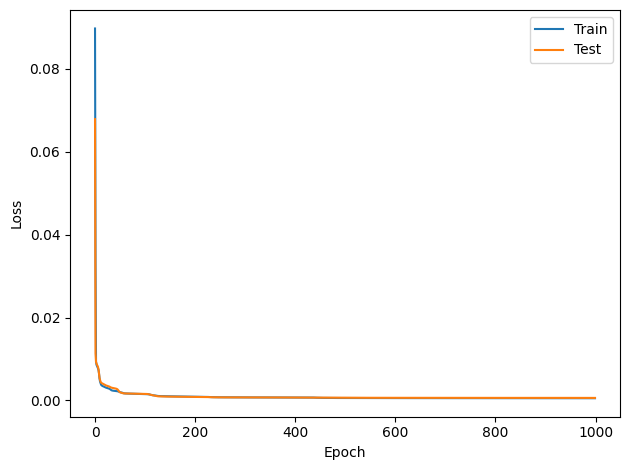

In [17]:
args = SimpleNamespace(**args)
model = model.fit(args)

In [18]:
tmp_train_loader = DataLoader(
    train_dataset, batch_size=1, shuffle=False
)
tmp_val_loader = DataLoader(
    val_dataset, batch_size=1, shuffle=False
)

In [19]:
def make_preds(model, data_loader):
    loss_dist = []
    model.eval()
    for x, _ in data_loader:
        x = x.to(device)
        sample = model(x)
        loss = torch.nn.MSELoss()(x, sample)
        loss_dist.append(loss.item())
    return loss_dist  

In [20]:
def plot_loss_dist(loss_dist):
    loss = []
    for i in loss_dist:
        loss.append((i,i))
    plt.scatter(*zip(*loss))
    plt.show()
    plt.close()
    
    plt.hist(loss_dist, bins=50)
    plt.show()
    plt.close()

In [21]:
train_loss_dist = make_preds(model, tmp_train_loader)

In [22]:
len(train_loss_dist)

1675

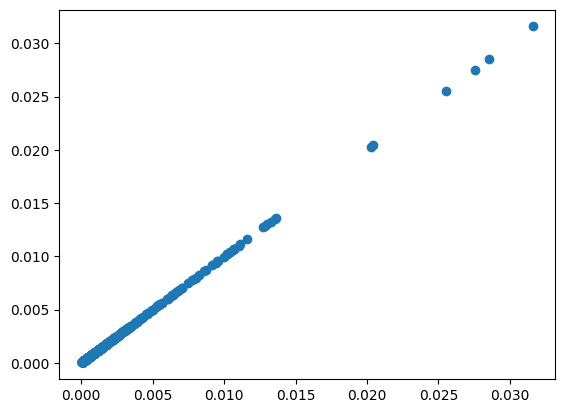

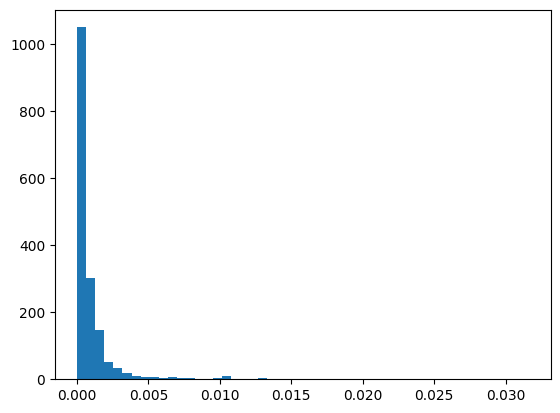

In [23]:
plot_loss_dist(train_loss_dist)

419


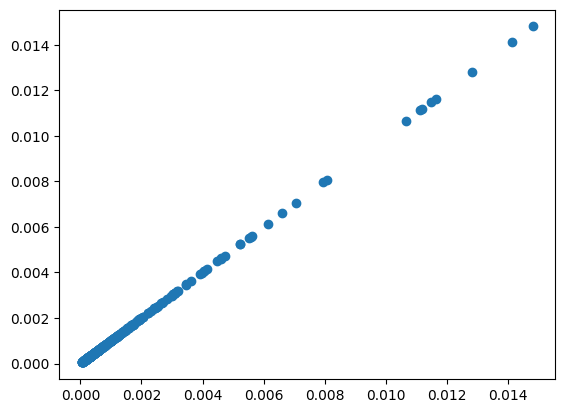

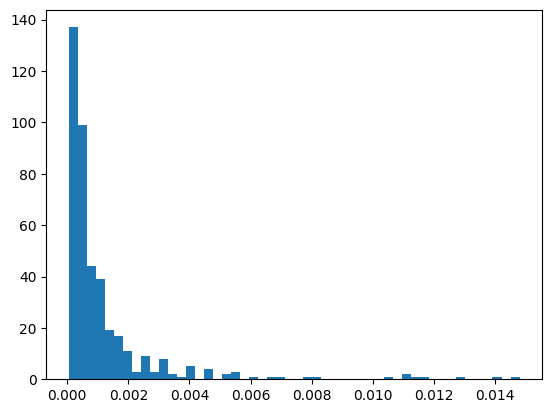

In [24]:
val_loss_dist = make_preds(model, tmp_val_loader)
print(len(val_loss_dist))
plot_loss_dist(val_loss_dist)

In [25]:
sorted_train = sorted(train_loss_dist, reverse=True)
print("Train", sorted_train[:10])
print("\n\n")

sorted_val = sorted(val_loss_dist, reverse=True)
print("Val", sorted_val[:10])
print("\n\n")

print(f"Train Mean: {statistics.mean(train_loss_dist)}, Median: {statistics.median(train_loss_dist)}")
print(f"Val Mean: {statistics.mean(val_loss_dist)}, Median: {statistics.mean(val_loss_dist)}")

Train [0.031593091785907745, 0.028540872037410736, 0.02754277177155018, 0.025536570698022842, 0.020416131243109703, 0.020270776003599167, 0.013615650124847889, 0.013546973466873169, 0.013245925307273865, 0.013011189177632332]



Val [0.014806353487074375, 0.014142712578177452, 0.012815645895898342, 0.011626592837274075, 0.011492650024592876, 0.011198906227946281, 0.011121191084384918, 0.010643617250025272, 0.008079634048044682, 0.00795576348900795]



Train Mean: 0.0010738543230682305, Median: 0.0005092684295959771
Val Mean: 0.0011915480557737176, Median: 0.0011915480557737176


In [26]:
np.mean(train_loss_dist) + 2*np.std(train_loss_dist), np.mean(train_loss_dist) + np.std(train_loss_dist)

(0.005459740339145746, 0.003266797331106988)

1555


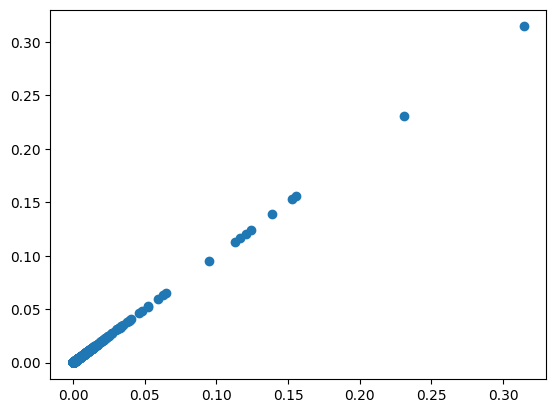

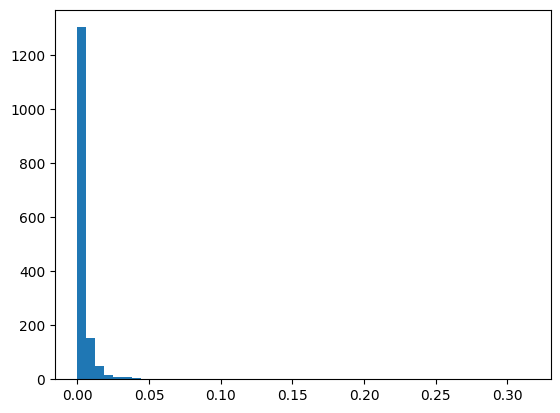

In [27]:
test_zero_loss_dist = make_preds(model, test_zero)
print(len(test_zero_loss_dist))
plot_loss_dist(test_zero_loss_dist)

In [28]:
sorted_test = sorted(test_zero_loss_dist, reverse=True)
print("Test zero", sorted_test[:10])
print("\n\n")

print(f"Test Mean: {statistics.mean(test_zero_loss_dist)}, Median: {statistics.median(test_zero_loss_dist)}")

Test zero [0.31452763080596924, 0.2310350090265274, 0.15564335882663727, 0.15278373658657074, 0.13909587264060974, 0.12399867177009583, 0.12050913274288177, 0.1166764572262764, 0.1129806637763977, 0.09489446878433228]



Test Mean: 0.004517187045766299, Median: 0.0015074526891112328


In [29]:
np.percentile(train_loss_dist, 20), np.percentile(val_loss_dist, 20), np.percentile(test_zero_loss_dist, 20)

(0.00021794636268168688, 0.00023420307843480262, 0.0005199849256314337)

In [30]:
zero_below, zero_above = [], [] 
for i in test_zero_loss_dist:
    if i < 0.00015:
        zero_below.append(i)
    else:
        zero_above.append(i)
len(zero_below), len(zero_above)

(24, 1531)

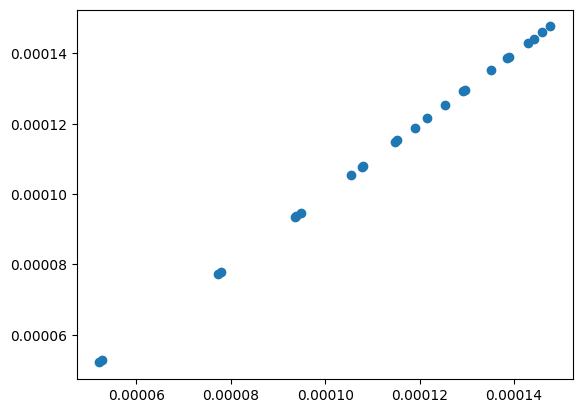

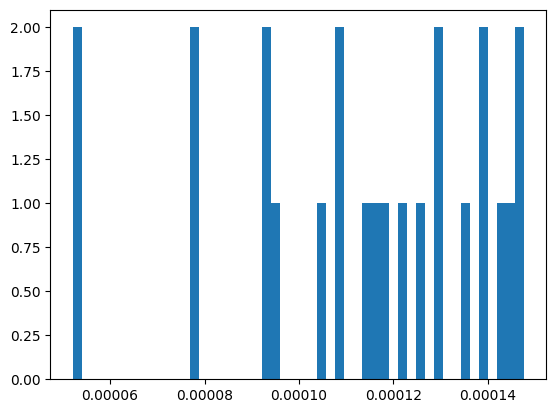

In [31]:
plot_loss_dist(zero_below)

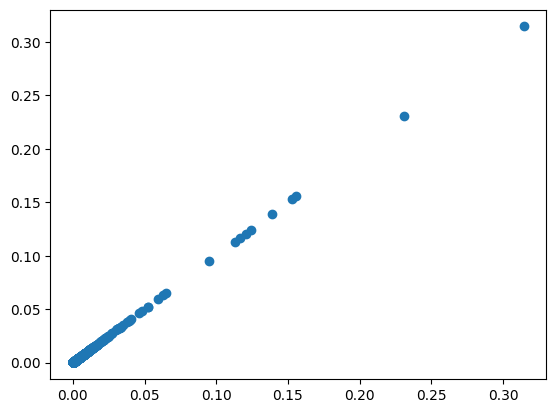

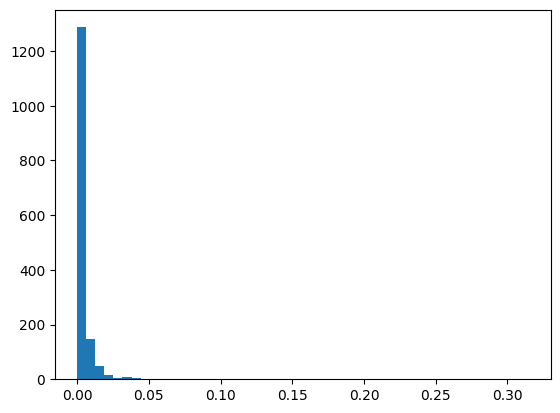

In [32]:
plot_loss_dist(zero_above)

In [33]:
test_loss_dist = make_preds(model, test_loader)
len(test_loss_dist)

1974

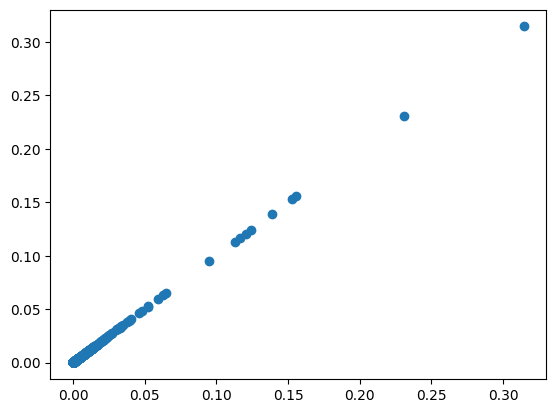

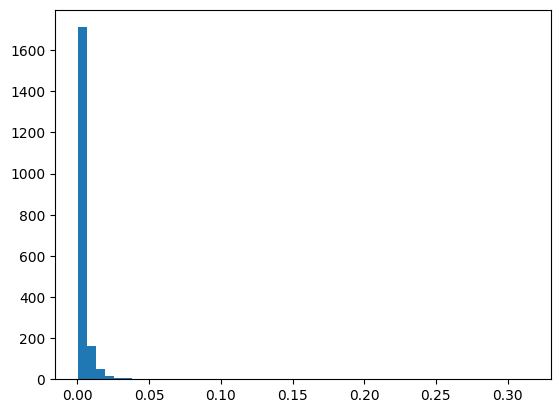

In [34]:
plot_loss_dist(test_loss_dist)

In [35]:
#total_losses = train_loss_dist[:]
#total_losses.extend(test_loss_dist)
total_losses = test_loss_dist
total_losses = np.array(total_losses)

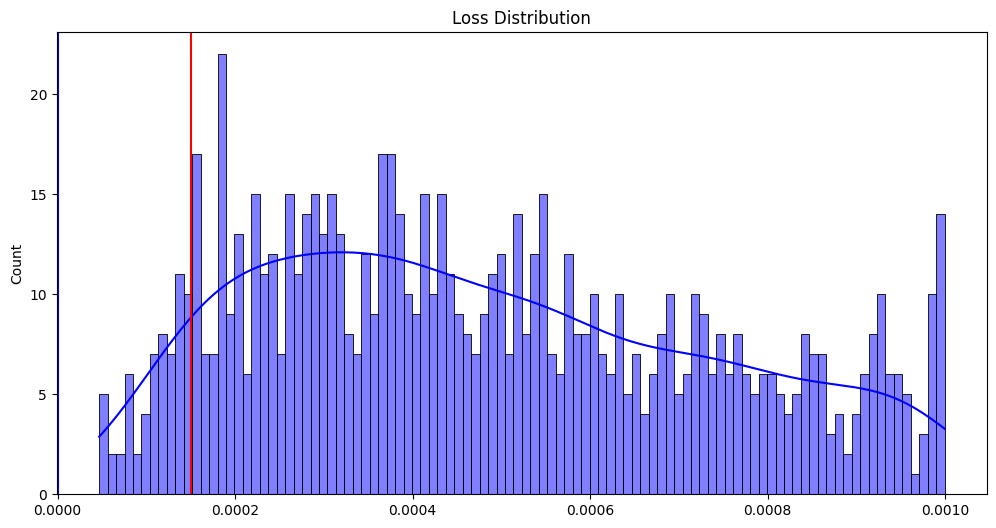

In [36]:
lower_threshold = 0.0
upper_threshold = 0.00015
plt.figure(figsize=(12,6))
plt.title('Loss Distribution')
sns.histplot( total_losses[total_losses < 0.001],bins=100,kde=True, color='blue')
plt.axvline(upper_threshold, 0.0, 10, color='r')
plt.axvline(lower_threshold, 0.0, 10, color='b')

In [45]:
def make_preds_and_classify(model, data_loader, threshold=1e-4):
    loss_dist = []
    y_true, y_pred = [], []
    y_scores = []
    model.eval()
    for x, y in data_loader:
        x = x.to(device)
        y_true.append(y)
        sample = model(x)
        loss = torch.nn.MSELoss()(x, sample)
        loss_dist.append(loss.item())
        if loss.item() < threshold:
            y_pred.append(0)
        else:
            y_pred.append(1)
        # np.exp(-losses) / np.sum(np.exp(-losses))

    losses = np.array(loss_dist)
    probs = np.exp(-losses) / np.sum(np.exp(-losses))
    
    m = np.median(losses)
    ad = np.abs(losses - m)
    mad = np.median(ad)
    probs2 =1/(1 + np.exp(-0.6745 * ad / mad))
    
    scaler = MinMaxScaler()
    scaler.fit(probs2.reshape(-1, 1))
    probs3 = scaler.transform(probs2.reshape(-1, 1))
    
    scaler = MinMaxScaler()
    scaler.fit(probs.reshape(-1, 1))
    probs4 = scaler.transform(probs2.reshape(-1, 1))
    
    probs5 = 1/(1 + np.exp(-losses))
    print(probs5.min(), probs5.max())
    
    scaler = MinMaxScaler()
    scaler.fit(probs5.reshape(-1, 1))
    probs6 = scaler.transform(probs5.reshape(-1, 1))
    
    y_true = torch.cat(y_true, dim=0)
    num_ones = torch.sum(y_true == 1).item()
    print("Num ones", num_ones)
    
    acc, precision, recall, f1 = get_classification_metrics(y_true.numpy(), np.array(y_pred))
    
    print("Probs2:", get_probability_measures(y_true.numpy(), probs2))

    print("Probs2",get_lift_demotion_scores(y_true.numpy(), probs2,
                                                            num_samples=int(0.1 * num_ones),
                                                            verbose=False))
    
    print("Probs3:", get_probability_measures(y_true.numpy(), probs3))

    print("Probs3",get_lift_demotion_scores(y_true.numpy(), probs3,
                                                            num_samples=int(0.1 * num_ones),
                                                            verbose=False))
    print("Probs4:", get_probability_measures(y_true.numpy(), probs4))

    print("Probs4",get_lift_demotion_scores(y_true.numpy(), probs4,
                                                            num_samples=int(0.1 * num_ones),
                                                            verbose=False))
    
    print("Probs5:", get_probability_measures(y_true.numpy(), probs5))

    print("Probs5",get_lift_demotion_scores(y_true.numpy(), probs5,
                                                            num_samples=int(0.1 * num_ones),
                                                            verbose=False))
    print("Probs6:", get_probability_measures(y_true.numpy(), probs6))

    print("Probs6",get_lift_demotion_scores(y_true.numpy(), probs6,
                                                            num_samples=int(0.1 * num_ones),
                                                            verbose=False))
    
    brier, roc_auc, pr_auc = get_probability_measures(y_true.numpy(), probs)

    lift, demotion, weighted = get_lift_demotion_scores(y_true.numpy(), probs,
                                                            num_samples=int(0.1 * num_ones),
                                                            verbose=False)
    
    return acc, precision, recall, f1, brier, roc_auc, pr_auc, lift, demotion, weighted, losses
  

In [46]:
acc, precision, recall, f1, brier, roc_auc, pr_auc, lift, demotion, weighted, loss_dist = make_preds_and_classify(model, test_loader, 
                        threshold=0.00015)
print(f"[Test] Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1: {f1}\n"
                f"\t\tBrier score loss: {brier}, ROC-AUC: {roc_auc}, PR-AUC: {pr_auc}\n"
                f"\t\tLift: {lift}, Demotion: {demotion}, Weighted Score: {weighted}\n")

0.5000117086528896 0.5779900179911233
Num ones 1555
Probs2: (0.17845873459175865, 0.5610303202388169, 0.8524807359953024)
Probs2 (0.9483870967741935, 0.1935483870967742, 0.7219354838709677)
Probs3: (0.3639811609739925, 0.5610303202388169, 0.8524807359953024)
Probs3 (0.9483870967741935, 0.1935483870967742, 0.7219354838709677)
Probs4: (None, 0.5610303202388169, 0.8524807359953024)
Probs4 (0.9483870967741935, 0.1935483870967742, 0.7219354838709677)
Probs5: (0.24918573523841483, 0.721578709068445, 0.8995468428244616)
Probs5 (0.9483870967741935, 0.5161290322580645, 0.8187096774193547)
Probs6: (0.7670546940130898, 0.721578709068445, 0.8995468428244616)
Probs6 (0.9483870967741935, 0.5161290322580645, 0.8187096774193547)
[Test] Accuracy: 0.795339412360689, Precision: 0.8011512297226583, Recall: 0.9845659163987138, F1: 0.8834391229082516
		Brier score loss: 0.7869433159670257, ROC-AUC: 0.278421290931555, PR-AUC: 0.6749313598290514
		Lift: 0.4838709677419355, Demotion: 0.05161290322580645, Weigh

In [39]:
np.percentile(loss_dist, 45)

0.001024422817863524

In [40]:
print(f"Test Mean: {statistics.mean(loss_dist)}, Median: {statistics.median(loss_dist)}")

Test Mean: 0.0038112890028043477, Median: 0.0011999660055153072


In [41]:
train_loss_dist = np.array(train_loss_dist)
test_zero_loss_dist = np.array(test_zero_loss_dist)

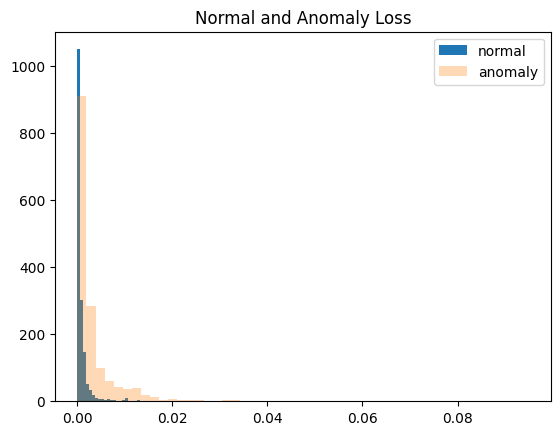

In [42]:
plt.hist(train_loss_dist[train_loss_dist < 0.1], bins=50, label='normal')
plt.hist(test_zero_loss_dist[test_zero_loss_dist < 0.1], bins=50, label='anomaly', alpha=0.3)
#plt.axvline(threshold, color='r', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))
plt.legend(loc='upper right')
plt.title("Normal and Anomaly Loss")
plt.show()